## Linguistic Case Study

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import boxplot
import itertools
import glob
from scipy import stats
import sys
sys.path.insert(0,'../..')
import g4l.display
from g4l import SmallestMaximizerCriterion
from g4l.estimators.ctm_scanner import CTMScanner
from g4l.estimators.prune import Prune
from g4l.evaluation.bootstrap import Bootstrap
from g4l.evaluation.t_test import TTest
from g4l.data import Sample


In [2]:
cache_dir = '../example1/cache'
X_bp = Sample('../example1/folha.txt', [0, 1, 2, 3, 4])
X_ep = Sample('../example1/publico.txt', [0, 1, 2, 3, 4])

In [3]:
ctm_scan = CTMScanner(penalty_interval=(0.1, 400), epsilon=0.01)
smc = SmallestMaximizerCriterion(ctm_scan, max_depth=4, read_cache_dir=cache_dir)

In [4]:
num_resamples = 200
bootstrap = Bootstrap(X_bp, partition_string='4')
small_resamples_bp = bootstrap.resample(num_resamples, size=len(X_bp.data) * 0.3)
large_resamples_bp = bootstrap.resample(num_resamples, size=len(X_bp.data) * 0.9)
t_test = TTest(small_resamples_bp, large_resamples_bp, alpha=0.01)

In [9]:
# Generating trees for Brazilian Portuguese (BP)
BP = smc.fit(X_bp, t_test, processors=3)

In [10]:
num_resamples = 200
bootstrap_ep = Bootstrap(X_ep, partition_string='4')
small_resamples_ep = bootstrap.resample(num_resamples, size=len(X_ep.data) * 0.3)
large_resamples_ep = bootstrap.resample(num_resamples, size=len(X_ep.data) * 0.9)
t_test = TTest(small_resamples_bp, large_resamples_bp, alpha=0.01)

In [11]:
# Generating trees for European Portuguese (BP)
EP = smc.fit(X_ep, t_test, processors=3)

Best tree for Brazilian Portuguese:
0000 0001 0010 002 0030 0102 012 0130 0201 021 0210 03 100 1030 1201 121 1210 13 20 200 2000 2001 2010 2102 212 2130 300 302 3030 32 3201 321 3210 33 330 4 42 4201 421 4210 43 430


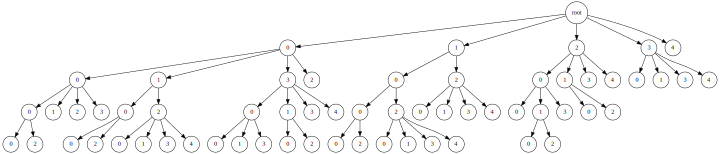

In [16]:
print("Best tree for Brazilian Portuguese:")
print(BP.best_tree().to_str())
g4l.display.draw_tree(BP.best_tree().to_str())

Best tree for European Portuguese:
0000 0001 0010 003 0103 012 013 0130 02 0210 030 100 1210 20 200 2000 2001 201 2010 21 2103 212 213 2130 300 303 32 3210 33 330 4 42 4210 43 430


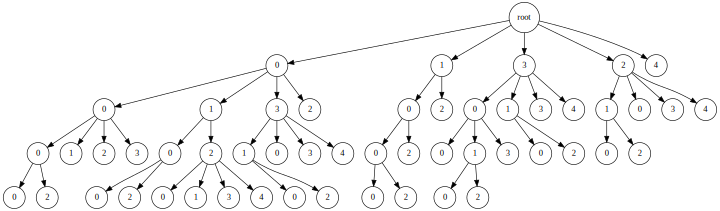

In [17]:
print("Best tree for European Portuguese:")
print(EP.best_tree().to_str())
g4l.display.draw_tree(EP.best_tree().to_str())

In [18]:
ll_ep = [x.log_likelihood() for x in EP.champion_trees]
num_contexts_ep = [len(x.leaves()) for x in EP.champion_trees]

ll_bp = [x.log_likelihood() for x in BP.champion_trees]
num_contexts_bp = [len(x.leaves()) for x in BP.champion_trees]

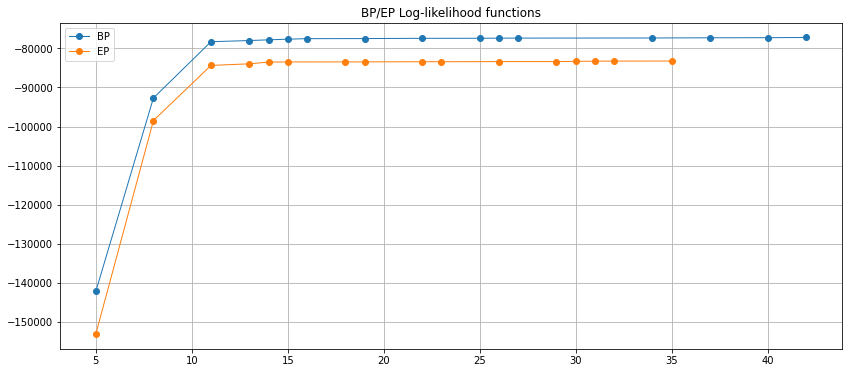

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(num_contexts_bp, ll_bp, marker='o', linewidth=1, label="BP")
plt.plot(num_contexts_ep, ll_ep, marker='o', linewidth=1, label="EP")
plt.title("BP/EP Log-likelihood functions")
plt.grid()
plt.legend()
plt.show()